# Challenge 03: Data Modelling: From Retrieval to Upload (1/2)

In this step, we will structure the data retrieved from Azure Document Intelligence (ADI) into the right format to be read by our systems in subsequent steps. 

The data will be outputted from the ADI as a JSON file, and it is our role to process and organize it. Some of the data will be structured into tables, while other data will be formatted as text. This step ensures that the extracted information is organized in a meaningful way for further analysis and usage.

As stated before, we need to make sure that our Function will know how to process:
- **Loan Forms:** Extract relevant details such as borrower information, loan amounts, and terms.
- **Loan Contract:** Identify and parse key contract elements like clauses, signatures, and dates.
- **Pay Stubs:** Retrieve data such as employee details, earnings, deductions, and net pay.

Not all customers will have provided all types of content, and during this Challenge we will be only be processing one file. We will combine in the next challenge the capabilities of a trigger, which will, at a time, also process one single document.

Due to the nature of this challenge, we will separate this challenge in the 3 different types of documents.

## Loan Agreement


Now we get to the last part of our logical set of documents on a loan application process: the final loan agreement contract has been created and signed. A loan agreement contract is a legally binding document between a lender and a borrower that outlines the terms and conditions of a loan. This contract specifies the loan amount, interest rate, repayment schedule, and any other obligations or rights of both parties. It is crucial as it provides clarity and protection for both the lender and the borrower, ensuring that both parties understand their responsibilities and the consequences of default. Additionally, it serves as a legal record that can be referenced in case of disputes, helping to prevent misunderstandings and enforce the agreed-upon terms.

The format of a loan agreement is, on its core, a text document that will not have a fixed structure. We should expect just as an input text document and therefore retrieve it as such. 

As we did in the previous steps, let's call the function that will retrieve the information inside the loanagreements folder, retrieving, once again, one single Loan Agreement.


In [2]:
import os
import json
import pandas as pd
from azure.storage.blob import BlobServiceClient
from dotenv import load_dotenv
import re
# Load environment variables from .env file
load_dotenv()

def read_json_files_from_blob(folder_path):
    # Retrieve the connection string from the environment variables
    connection_string = os.getenv('connection_string')

    # Ensure the connection string is not None
    if connection_string is None:
        raise ValueError("The connection string environment variable is not set.")

    # Create a BlobServiceClient
    blob_service_client = BlobServiceClient.from_connection_string(connection_string)

    # Get the container client
    container_client = blob_service_client.get_container_client("bankdetail")

    # List all blobs in the specified folder
    blob_list = container_client.list_blobs(name_starts_with=folder_path)

    # Filter out JSON files and read their contents
    for blob in blob_list:
        if blob.name.endswith('.json'):
            blob_client = container_client.get_blob_client(blob.name)
            blob_data = blob_client.download_blob().readall()
            data = json.loads(blob_data)
            return data 

#### Loan Agreements

In [3]:
loanagreement = read_json_files_from_blob("loanagreements")

In [4]:
import json
import re

def clean_json_data(json_data):
    # Extract relevant text content from the JSON
    content = []

    # Extract text from paragraphs
    paragraphs = json_data.get("paragraphs", [])
    for paragraph in paragraphs:
        content.append(paragraph.get("text", "").strip())

    # Extract text from pages and lines
    pages = json_data.get("pages", [])
    for page in pages:
        for line in page.get("lines", []):
            content.append(line.get("text", "").strip())

    # Join all text content into a single string with spaces between components
    plain_text_content = " ".join(content)

    # Extract Customer ID using regex
    pattern = r"Customer ID:\s*(\d+)"
    match = re.search(pattern, plain_text_content)
    customer_id = match.group(1) if match else None
    return plain_text_content, customer_id

# Clean the JSON data and extract Customer ID
loanagreement_structured, customer_id = clean_json_data(loanagreement)

In [5]:
from azure.cosmos import CosmosClient, exceptions, PartitionKey
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Cosmos DB connection details from environment variables
endpoint = os.getenv("COSMOS_DB_ENDPOINT")
key = os.getenv("COSMOS_DB_KEY")

def upload_text_to_cosmos_db(text_content, container_name):
    # Check if the text is empty
    if not text_content:
        print("The text content is empty. No data to upload.")
        return
    
    # Initialize the Cosmos client
    client = CosmosClient(endpoint, key)
    
    try:
        # Create or get the database
        database = client.create_database_if_not_exists(id="ContosoDB")
        
        # Create or get the container
        container = database.create_container_if_not_exists(
            id=container_name,
            partition_key=PartitionKey(path=f"/id"),
            offer_throughput=400
        )
    except exceptions.CosmosHttpResponseError as e:
        print(f"An error occurred while creating the database or container: {e.message}")
        return
    
    # Create a document with the text content and partition key
    document = {
        'id': str(customer_id),  # Generate a unique ID for the document
        'content': text_content,  # Store the plain text as 'content'
    }
    
    # Upload the document to the container
    try:
        container.create_item(body=document)
        loanagreement_json = document
        print(f"Text content uploaded successfully with ID '{document['id']}' in Cosmos DB.")
    except exceptions.CosmosHttpResponseError as e:
        print(f"An error occurred while uploading the document: {e.message}")
    return document

### Upload Loan Agreements

In [6]:
loanjson = upload_text_to_cosmos_db(loanagreement_structured, "LoanAgreements")

An error occurred while uploading the document: (Conflict) Entity with the specified id already exists in the system., {"Summary":{"DirectCalls":{"(409, 0)":1},"RegionsContacted":1,"GatewayCalls":{"(200, 0)":3,"(304, 0)":1}},"name":"HandleDocumentRequest","id":"ade98904-158e-40e0-94e8-9d86690028f5","start time":"08:19:34:957","duration in milliseconds":25.5691,"data":{"Client Side Request Stats":{"Id":"AggregatedClientSideRequestStatistics","ContactedReplicas":[{"Count":1,"Uri":"rntbd://cdb-ms-prod-swedencentral1-be62.documents.azure.com:14073/apps/928c0c85-23d6-43f2-8764-1493aa2e804f/services/f6e1c01a-d183-4817-8dfe-d4f0b9ea4283/partitions/d69f5c80-2269-4525-aed5-d7162725abda/replicas/133698723051945831p"},{"Count":1,"Uri":"rntbd://cdb-ms-prod-swedencentral1-be62.documents.azure.com:14311/apps/928c0c85-23d6-43f2-8764-1493aa2e804f/services/f6e1c01a-d183-4817-8dfe-d4f0b9ea4283/partitions/d69f5c80-2269-4525-aed5-d7162725abda/replicas/133698723051945832s"},{"Count":1,"Uri":"rntbd://cdb-ms

Now go back to your Azure Cosmos DB, check the container where the information of **Loan Agreements**. You should see a document that should be similar to this:

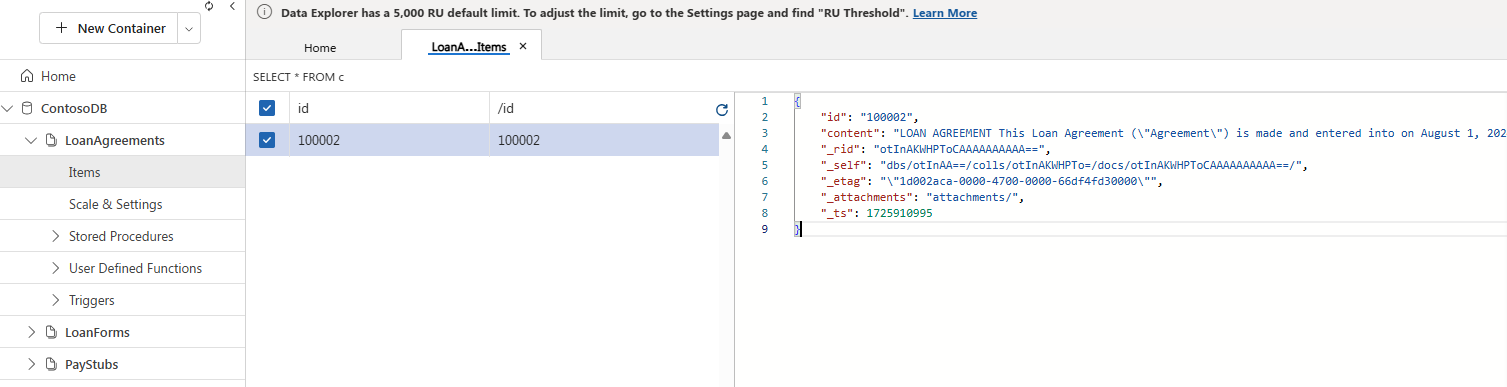

What we know, and due to this natural language nature, the content of our json is a long string, unlike the previous two examples that we have covered. But that's not what we want. The main goal of this process is to structure this information. So what can we do?

In [30]:
import os
from pydantic import BaseModel
from openai import AzureOpenAI
from dotenv import load_dotenv
from typing import List

load_dotenv()

# Ensure environment variables are set
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
api_key = os.getenv("AZURE_OPENAI_KEY")

if not azure_endpoint or not api_key:
    raise ValueError("AZURE_OPENAI_ENDPOINT and AZURE_OPENAI_KEY must be set")

client = AzureOpenAI(
  azure_endpoint=azure_endpoint, 
  api_key=api_key,  
  api_version="2024-08-06"
)

class Step(BaseModel):
    explanation: str
    output: str

class MathResponse(BaseModel):
    steps: List[Step]
    final_answer: str

completion = client.beta.chat.completions.parse(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are a helpful math tutor."}
    ],
    response_format=MathResponse,
)

message = completion.choices[0].message
if message.parsed:
    print(message.parsed.steps)
    print("answer: ", message.parsed.final_answer)
else:
    print(message.refusal)


NotFoundError: Error code: 404 - {'error': {'code': '404', 'message': 'Resource not found'}}